In [2]:
import numpy as np
import numpy.random as rn
import numpy.linalg as la
import matplotlib.pyplot as plt
import time

from __future__ import division

NUM_TRIPLES = 3

### Gradient and subgradient descent:

Consider three quadratics, as given by:
$$
f_i(x) = \frac{1}{2} x^{\top}Q_ix + q_i^{\top} x + c_i,
$$
for the three triples $(Q_i,q_i,c_i)$, $i=1,2,3$ given below.

In [3]:
Q1 = np.array([[ 1.17091573, -0.03686123, -0.1001259 ],
       [-0.03686123,  1.03835691,  0.17285956],
       [-0.1001259 ,  0.17285956,  1.06072736]])
Q2 = np.array([[ 15.27095759,  -1.97915834, -14.22190153],
       [ -1.97915834,   0.34660759,   1.91586927],
       [-14.22190153,   1.91586927,  15.76943482]])
Q3 = np.array([[28.59657006,  0.3684004 ,  0.90750259],
       [ 0.3684004 , 28.11480924,  0.81866989],
       [ 0.90750259,  0.81866989, 28.7886207 ]])
q1 = np.array([-4.68686663, -0.89027884, -1.57340281])
q2 = np.array([ 6.75973216,  1.23223936, -0.87956749])
q3 = np.array([ 0.8684369 , -4.69970837, -1.09690726])
c1 = 1.61888566
c2 = -2.66426693
c3 = 0.84184738

### Implementing Gradient Descent:

Using stepsize $0.1$, plotting function val vs iteration num:

In [4]:
def f(Q, q, c, x):
    return 1/2 * x.T @ Q @ x + q.T @ x + c

def dx(Q, q, x):
    return Q @ x + q.reshape(NUM_TRIPLES, 1)

def gd(Q, q, c, x, eta, n):
    res = []
    for i in range(n):
        res.append(f(Q, q, c, x)[0][0])
        x = x - eta * dx(Q, q, x)
    return x, res

def plt_f(res, id):
    plt.title('Function Value vs Iteration for Q{}'.format(id))
    plt.plot(res)
    plt.show()

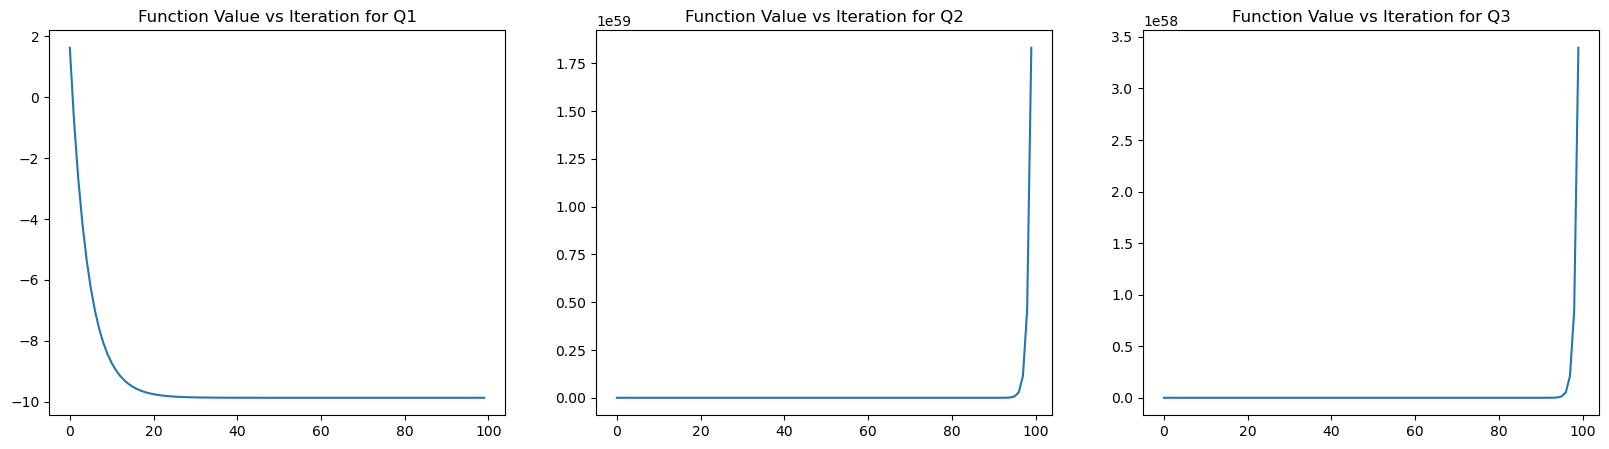

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=NUM_TRIPLES, sharex=True, figsize=(20, 5))

Q = [Q1, Q2, Q3]
q = [q1, q2, q3]
c = [c1, c2, c3]
eta = 0.1
n_iter = 100

for i in range(NUM_TRIPLES):
    x = np.zeros(shape=(NUM_TRIPLES,1))
    x, res = gd(Q[i], q[i], c[i], x, eta, n_iter)
    axes[i].set_title(f'Function Value vs Iteration for Q{i+1}')
    axes[i].plot(res)

plt.show()

After plotting the function value versus iteration for the three triples $(Q_i,q_i,c_i)$ with step-size `eta=0.1` and `n_iter=100` iterations, we see that only $(Q_1,q_1,c_1)$ converges, minimizing the loss function over the $100$ iterations, while $(Q_2,q_2,c_2)$ and $(Q_3,q_3,c_3)$ diverges with `eta=0.1`, growing larger over the $100$ iterations.

### Modifying stepsize for each quadratic

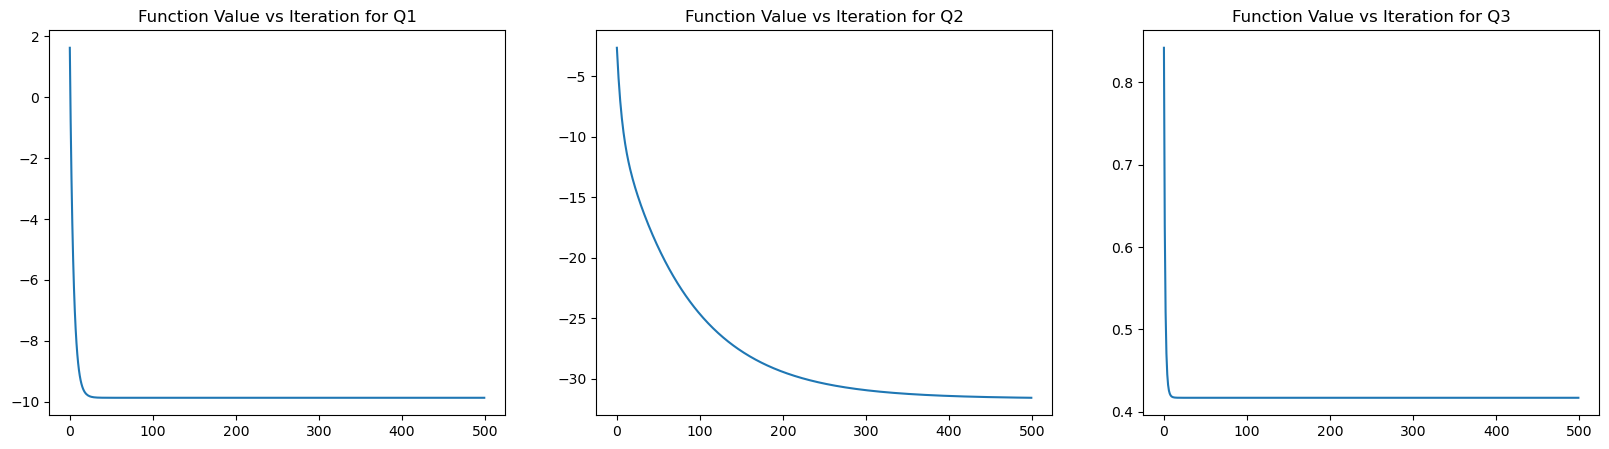

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=NUM_TRIPLES, sharex=True, figsize=(20, 5))

Q = [Q1, Q2, Q3]
q = [q1, q2, q3]
c = [c1, c2, c3]
eta = [0.1, 0.066, 0.06]
n_iter = 500

for i in range(NUM_TRIPLES):
    x = np.zeros(shape=(NUM_TRIPLES,1))
    x, res = gd(Q[i], q[i], c[i], x, eta[i], n_iter)
    axes[i].set_title(f'Function Value vs Iteration for Q{i+1}')
    axes[i].plot(res)

plt.show()

The selected step-sizes `eta_i` for `i=1,2,3` were `eta_1=0.1`, `eta_2=0.066` and `eta_3=0.06` when using `n_iter=500` iterations. To select a step size `eta` that gives fast convergence, we start at base `eta=0.1` and find the tipping point for the graph when it went from being an increasing function to a decreasing function. We use an inverse relationship approach to the step size and function value: decreasing the step size when the function value was increasing and vice versa.

Note that rates of convergence are not the same. The rates of convergence is dependent on the smoothness and convexity. Each step of SGD is calculating an approximation rather than the gradient.

### Problem 2: Sub-gradient Method

Consider a least squares problem with $\ell^1$ regularization:
$$
\min_x \left[f(x) = \frac{1}{2}\|{Ax-b}\|_2^2 + \lambda \|{x}\|_1 \right]
$$

Also called LASSO (least absolute shrinkage and selection operator),used to induce *sparse* solutions with few nonzero elements in $x$, which can have advantages in terms of computation and interpretability. This problem is nonsmooth due to the regularization term. It is also not strongly convex when $A$ has more columns than rows. We minimize $f$ using a subgradient method.

In [7]:
def descent(update, A, b, reg, T=int(1e4)):
    x = np.zeros(A.shape[1])
    error = []
    l1 = []
    for t in range(T):
        x = update(x, A, b, t, reg)
        if (t % 1 == 0) or (t == T - 1):
            error.append(la.norm(np.dot(A, x) - b, ord=1))
            l1.append(np.sum(abs(x)))
            assert not np.isnan(error[-1])
    return x, error, l1

def plt_err(error_sg, save=False):
    plt.clf()
    plt.plot(error_sg, label='Subgradient')
    plt.title('Error')
    plt.legend()
    plt.show()
    if save: plt.savefig('error.eps')

def plt_reg(l1_sg, save=False):
    plt.clf()
    plt.plot(l1_sg, label='Subgradient')
    plt.title("$\ell^1$ Norm")
    plt.legend()
    plt.show()
    if save: plt.savefig('l1.eps')

def plt_both(error_sg, l1_sg):
    plt.clf()
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(20, 5))
    axes[0].plot(error_sg, label='Subgradient')
    axes[0].set_title('Error')
    axes[0].legend()
    axes[1].plot(l1_sg, label='Subgradient')
    axes[1].set_title("$\ell^1$ Norm")
    axes[1].legend()
    plt.show()

We use a decreasing step size of $\eta_t = c/t$ with some constant $c$ that (roughly) optimize the empirical performance.

<Figure size 640x480 with 0 Axes>

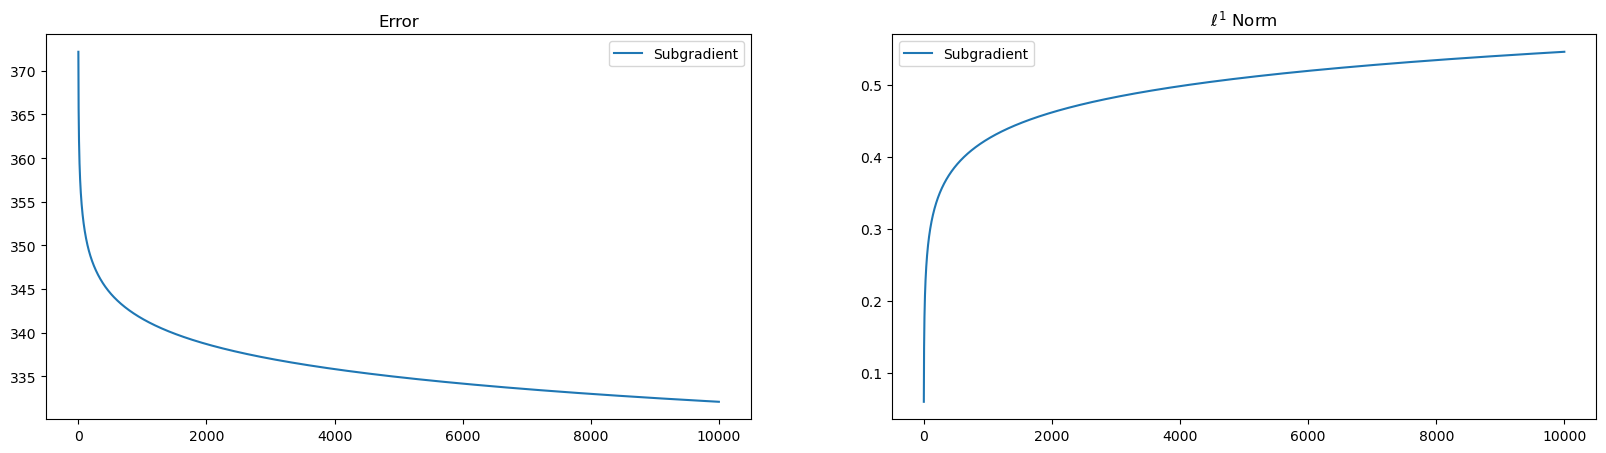

In [8]:
def subgradient(x, A, b, t, lam, c=1e-5):
    g = A.T @ A @ x - 2 * A.T @ b + lam * np.sign(x)
    x = x - c/(t+1) * g
    return x

def main():
    A = np.load("A.npy")
    b = np.load("b.npy")
    T = int(1e4)
    x_sg, error_sg, l1_sg = descent(subgradient, A, b, reg=0.1, T=T)
    plt_both(error_sg, l1_sg)

if __name__ == "__main__":
    main()

Using a slower decreasing step size $\eta_t = c/\sqrt{t+1}$

<Figure size 640x480 with 0 Axes>

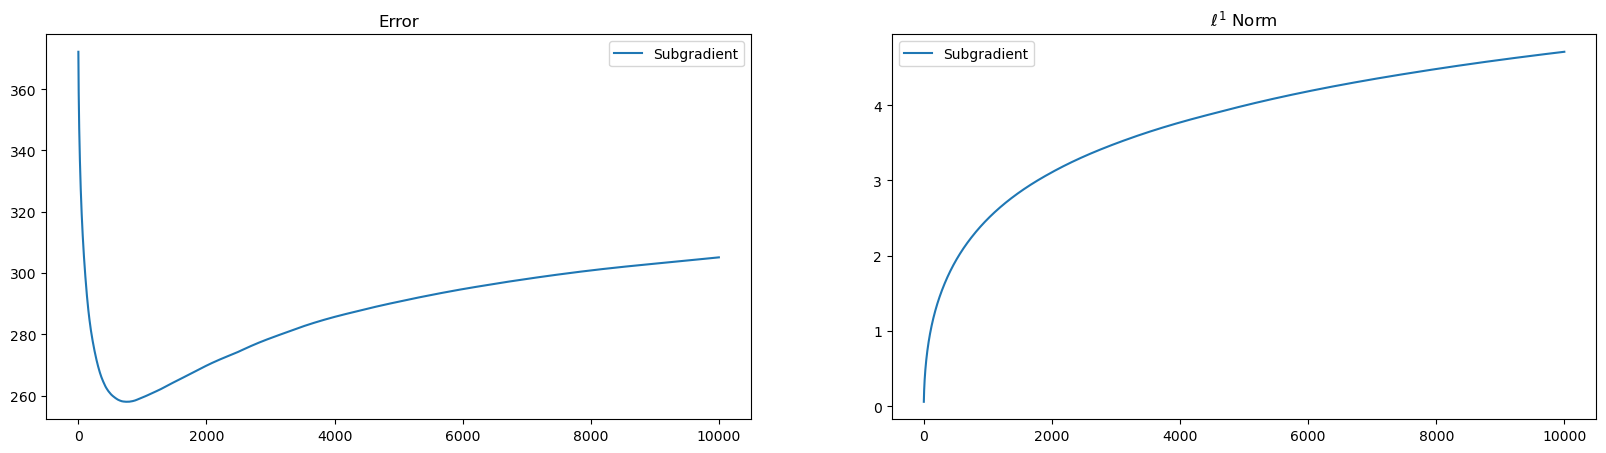

In [9]:
def subgradient(x, A, b, t, lam, c=1e-5):
    g = A.T @ A @ x - 2 * A.T @ b + lam * np.sign(x)
    x = x - c/np.sqrt(t+1) * g
    return x

def main():
    A = np.load("A.npy")
    b = np.load("b.npy")
    T = int(1e4)
    x_sg, error_sg, l1_sg = descent(subgradient, A, b, reg=0.1, T=T)
    plt_both(error_sg, l1_sg)

if __name__ == "__main__":
    main()

Using a fixed stepsize:

<Figure size 640x480 with 0 Axes>

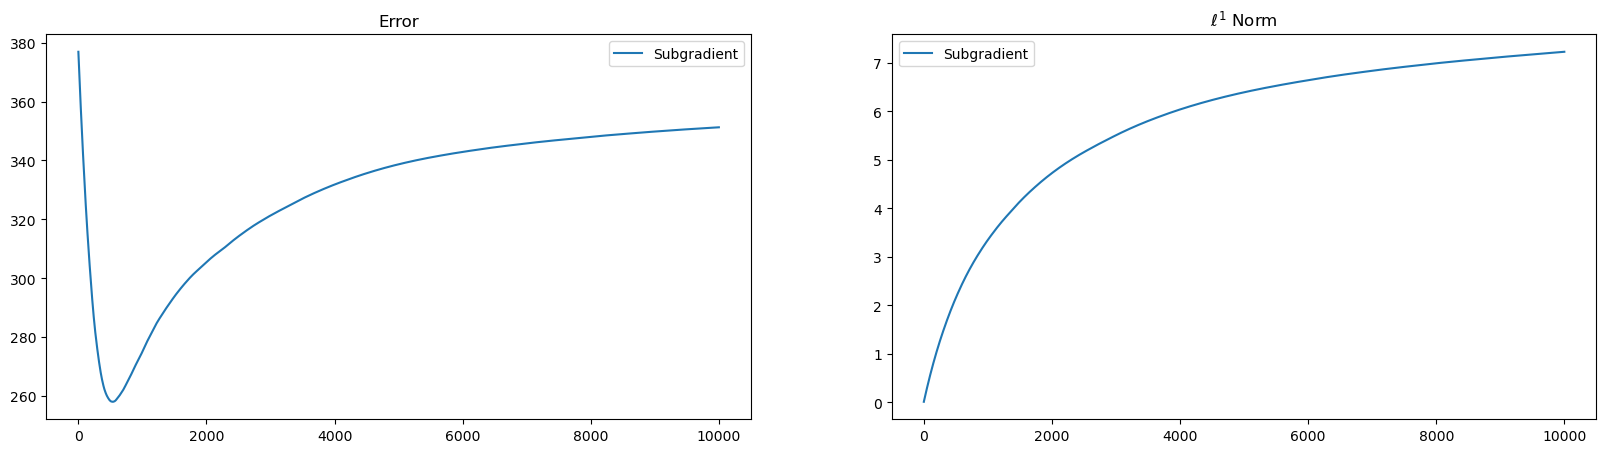

In [10]:
def subgradient(x, A, b, t, lam, c=1e-5):
    c = 1e-6
    g = A.T @ A @ x - 2 * A.T @ b + lam * np.sign(x)
    x = x - c * g
    return x

def main():
    A = np.load("A.npy")
    b = np.load("b.npy")
    T = int(1e4)
    x_sg, error_sg, l1_sg = descent(subgradient, A, b, reg=0.1, T=T)
    plt_both(error_sg, l1_sg)

if __name__ == "__main__":
    main()

A fixed step-size with `c=1e-6` (part c) minimizes the error rate relatively faster than a slowly decreasing step-size with `c=1e-5` (part a,b) within the same number of iterations `T=int(1e4)`. Naturally, the delta in the subgradient decreases faster when using step-size $\eta_t = c/t$ over $\eta_t = c/\sqrt{n+1}$ and $\eta_t = c/\sqrt{n+1}$ over $\eta_t = c$.

Using the graphs from part (b) and part (c), we see that the decreasing step-size $\eta_t = c/t$ in part (a) failed to converge, hovering around $335$ at the end of iteration. Overall, part (b) performed the best as it converges with a smaller L1-norm.